In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'Arial'

import geopandas as gpd

from functools import reduce

pd.set_option('display.max_rows', 3)

import warnings
warnings.filterwarnings('ignore')

# Part 1: Complaint patterns

### ***Fig.1a: spatial distribution***

In [2]:
df_complaint_year = pd.read_csv(r'Dataset/Dataset_311.csv', index_col=0)
df_complaint_year['TractFIPS'] = df_complaint_year['TractFIPS'].astype(float)
df_complaint_year['TractFIPS'] = df_complaint_year['TractFIPS'].astype(str)
df_complaint_year['TractFIPS'] = df_complaint_year['TractFIPS'].str.zfill(13)

complaint_cols = df_complaint_year.columns[df_complaint_year.columns.get_loc('AirQuality') : df_complaint_year.columns.get_loc('Water') + 1]
df_complaint_year[complaint_cols] = df_complaint_year[complaint_cols].div(df_complaint_year['TotalPopulation'], axis=0)

df_complaint = df_complaint_year.groupby('TractFIPS')[complaint_cols].sum().reset_index()
df_complaint['TotalComplaints'] = df_complaint[complaint_cols].sum(axis=1)

gdf_ct_ = gpd.read_file(r'Dataset/CT_SHP/Dataset_CT.shp')
df_complaint_sum = df_complaint[['TractFIPS','TotalComplaints']]
gdf_ct_sum = pd.merge(gdf_ct_, df_complaint_sum, on='TractFIPS')

city_list = np.unique(gdf_ct_sum['City']) 

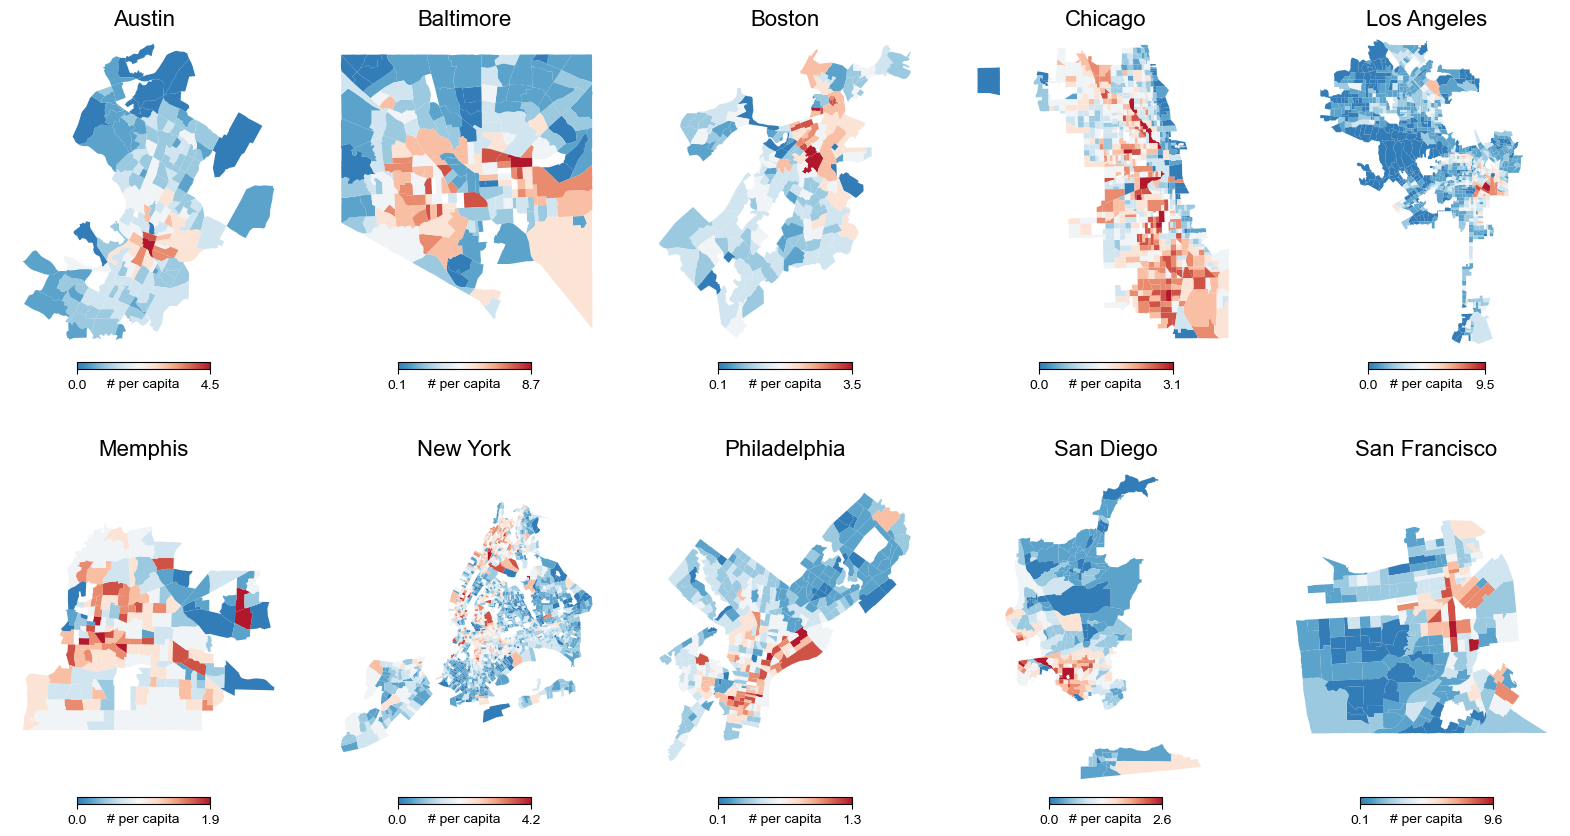

In [3]:
import importlib
import my_vis
importlib.reload(my_vis)
from my_vis import visualize_spatial_distribution

colors_truncated = plt.cm.RdBu_r
new_colors = mcolors.LinearSegmentedColormap.from_list(
    'new_colors', colors_truncated(np.linspace(0.15, 0.9, 256))
)

fig = visualize_spatial_distribution(
                                    gdf=gdf_ct_sum,
                                    city_list=city_list,
                                    column='TotalComplaints',
                                    figsize=(20, 10),
                                    cmap=new_colors,
                                    k=10,
                                    linewidth=0.001,
                                    title_y_row1=0.885,
                                    title_y_row2=0.455
                                    )

fig.savefig(r'YourImagePath/Figure1a.pdf', dpi=600, bbox_inches='tight')

### ***Fig.1b: thematic structures***

In [4]:
city_sum = df_complaint_year.groupby('City')[complaint_cols].mean().reset_index()

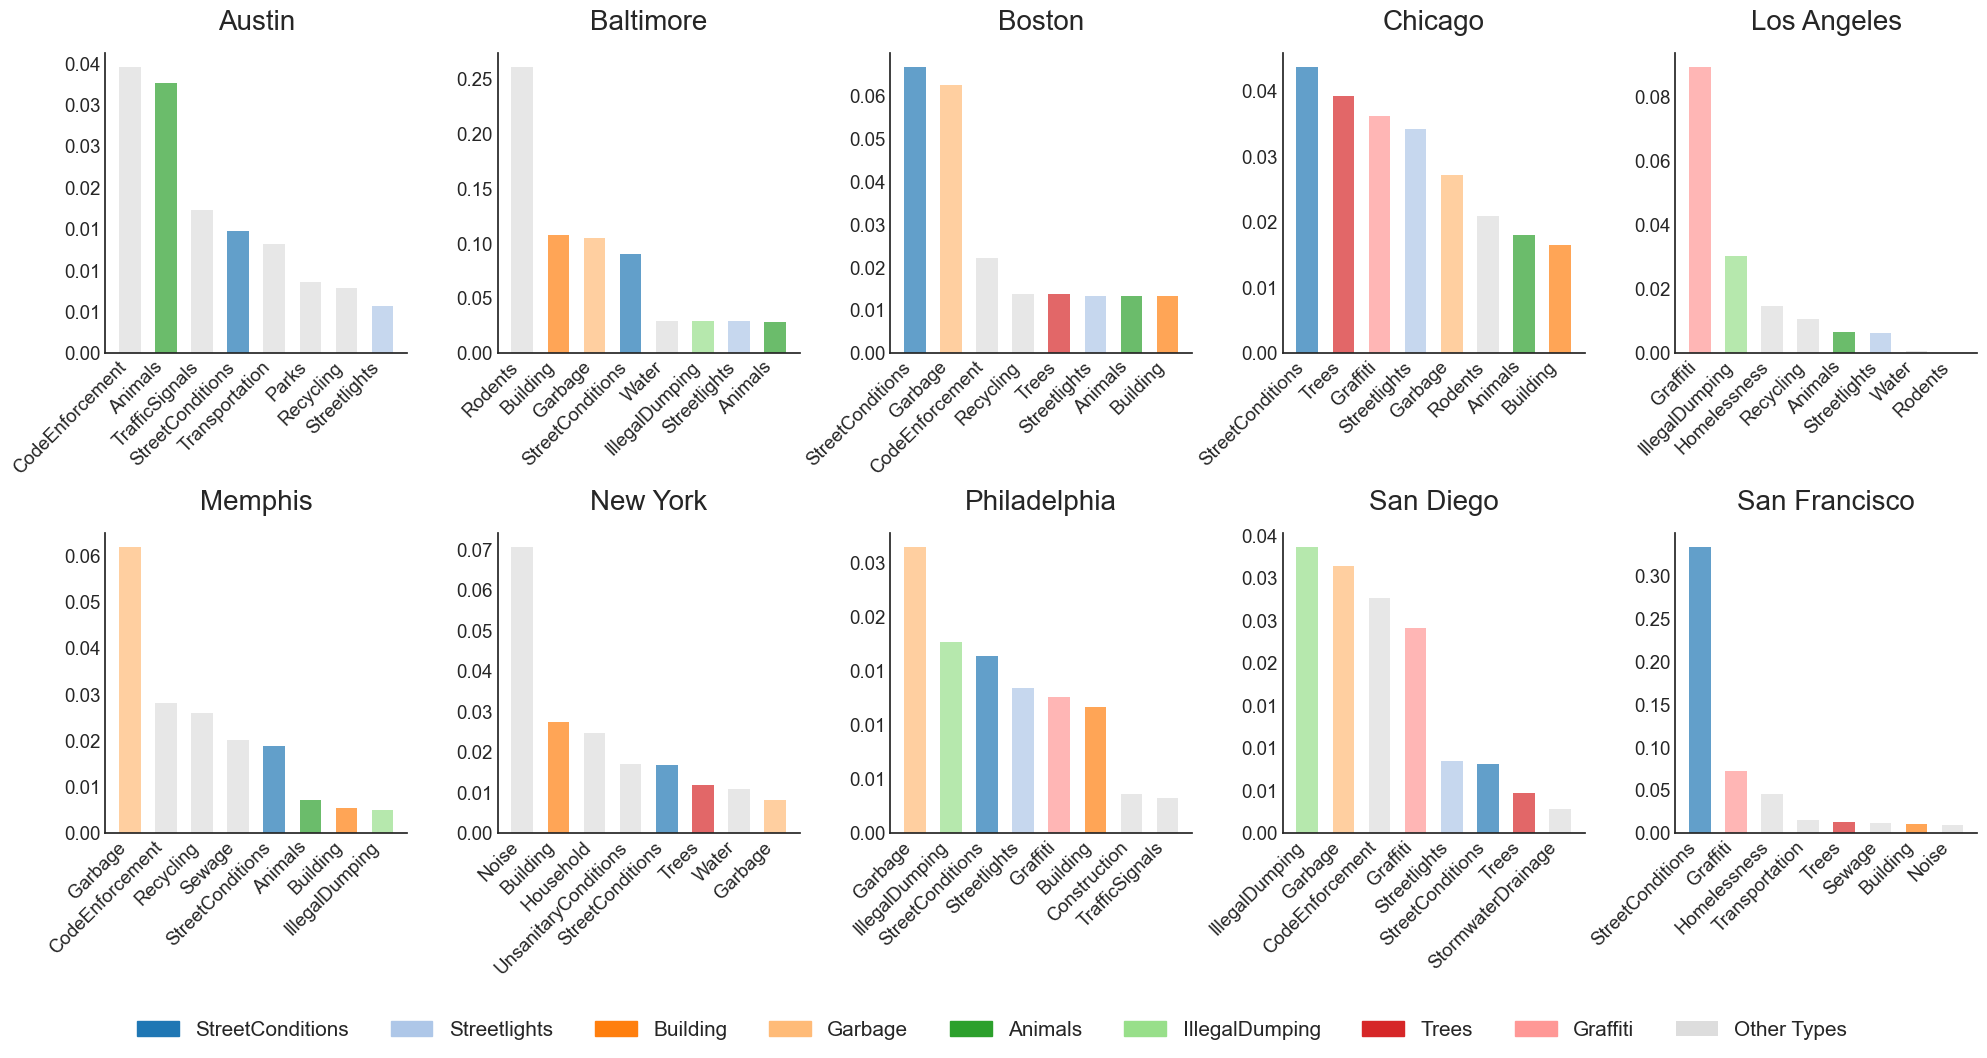

In [5]:
import importlib
import my_vis
importlib.reload(my_vis)
from my_vis import visualize_thematic_structures

fig = visualize_thematic_structures(
                                    city_sum=city_sum,
                                    num_top_types=8,
                                    top_n_to_color=8,
                                    width=0.6,
                                    alpha=0.7
                                    )

fig.savefig(r'YourImagePath/Figure1b.pdf', dpi=600, bbox_inches='tight')

# Part2: Predictive performance

### ***Fig.2a: complaint-based predictions***

In [6]:
df_pred_complaint_ = pd.read_csv(r'ResultTables/ComplaintBasedPredictions_2022for2023.csv')
ny_rows = df_pred_complaint_[df_pred_complaint_['City'] == 'New York']
other_rows = df_pred_complaint_[df_pred_complaint_['City'] != 'New York']
df_pred_complaint = pd.concat([ny_rows, other_rows]).reset_index(drop=True)

df_metirc_complaint = pd.read_csv(r'ResultTables/ComplaintBasedMetrics_2022for2023.csv')

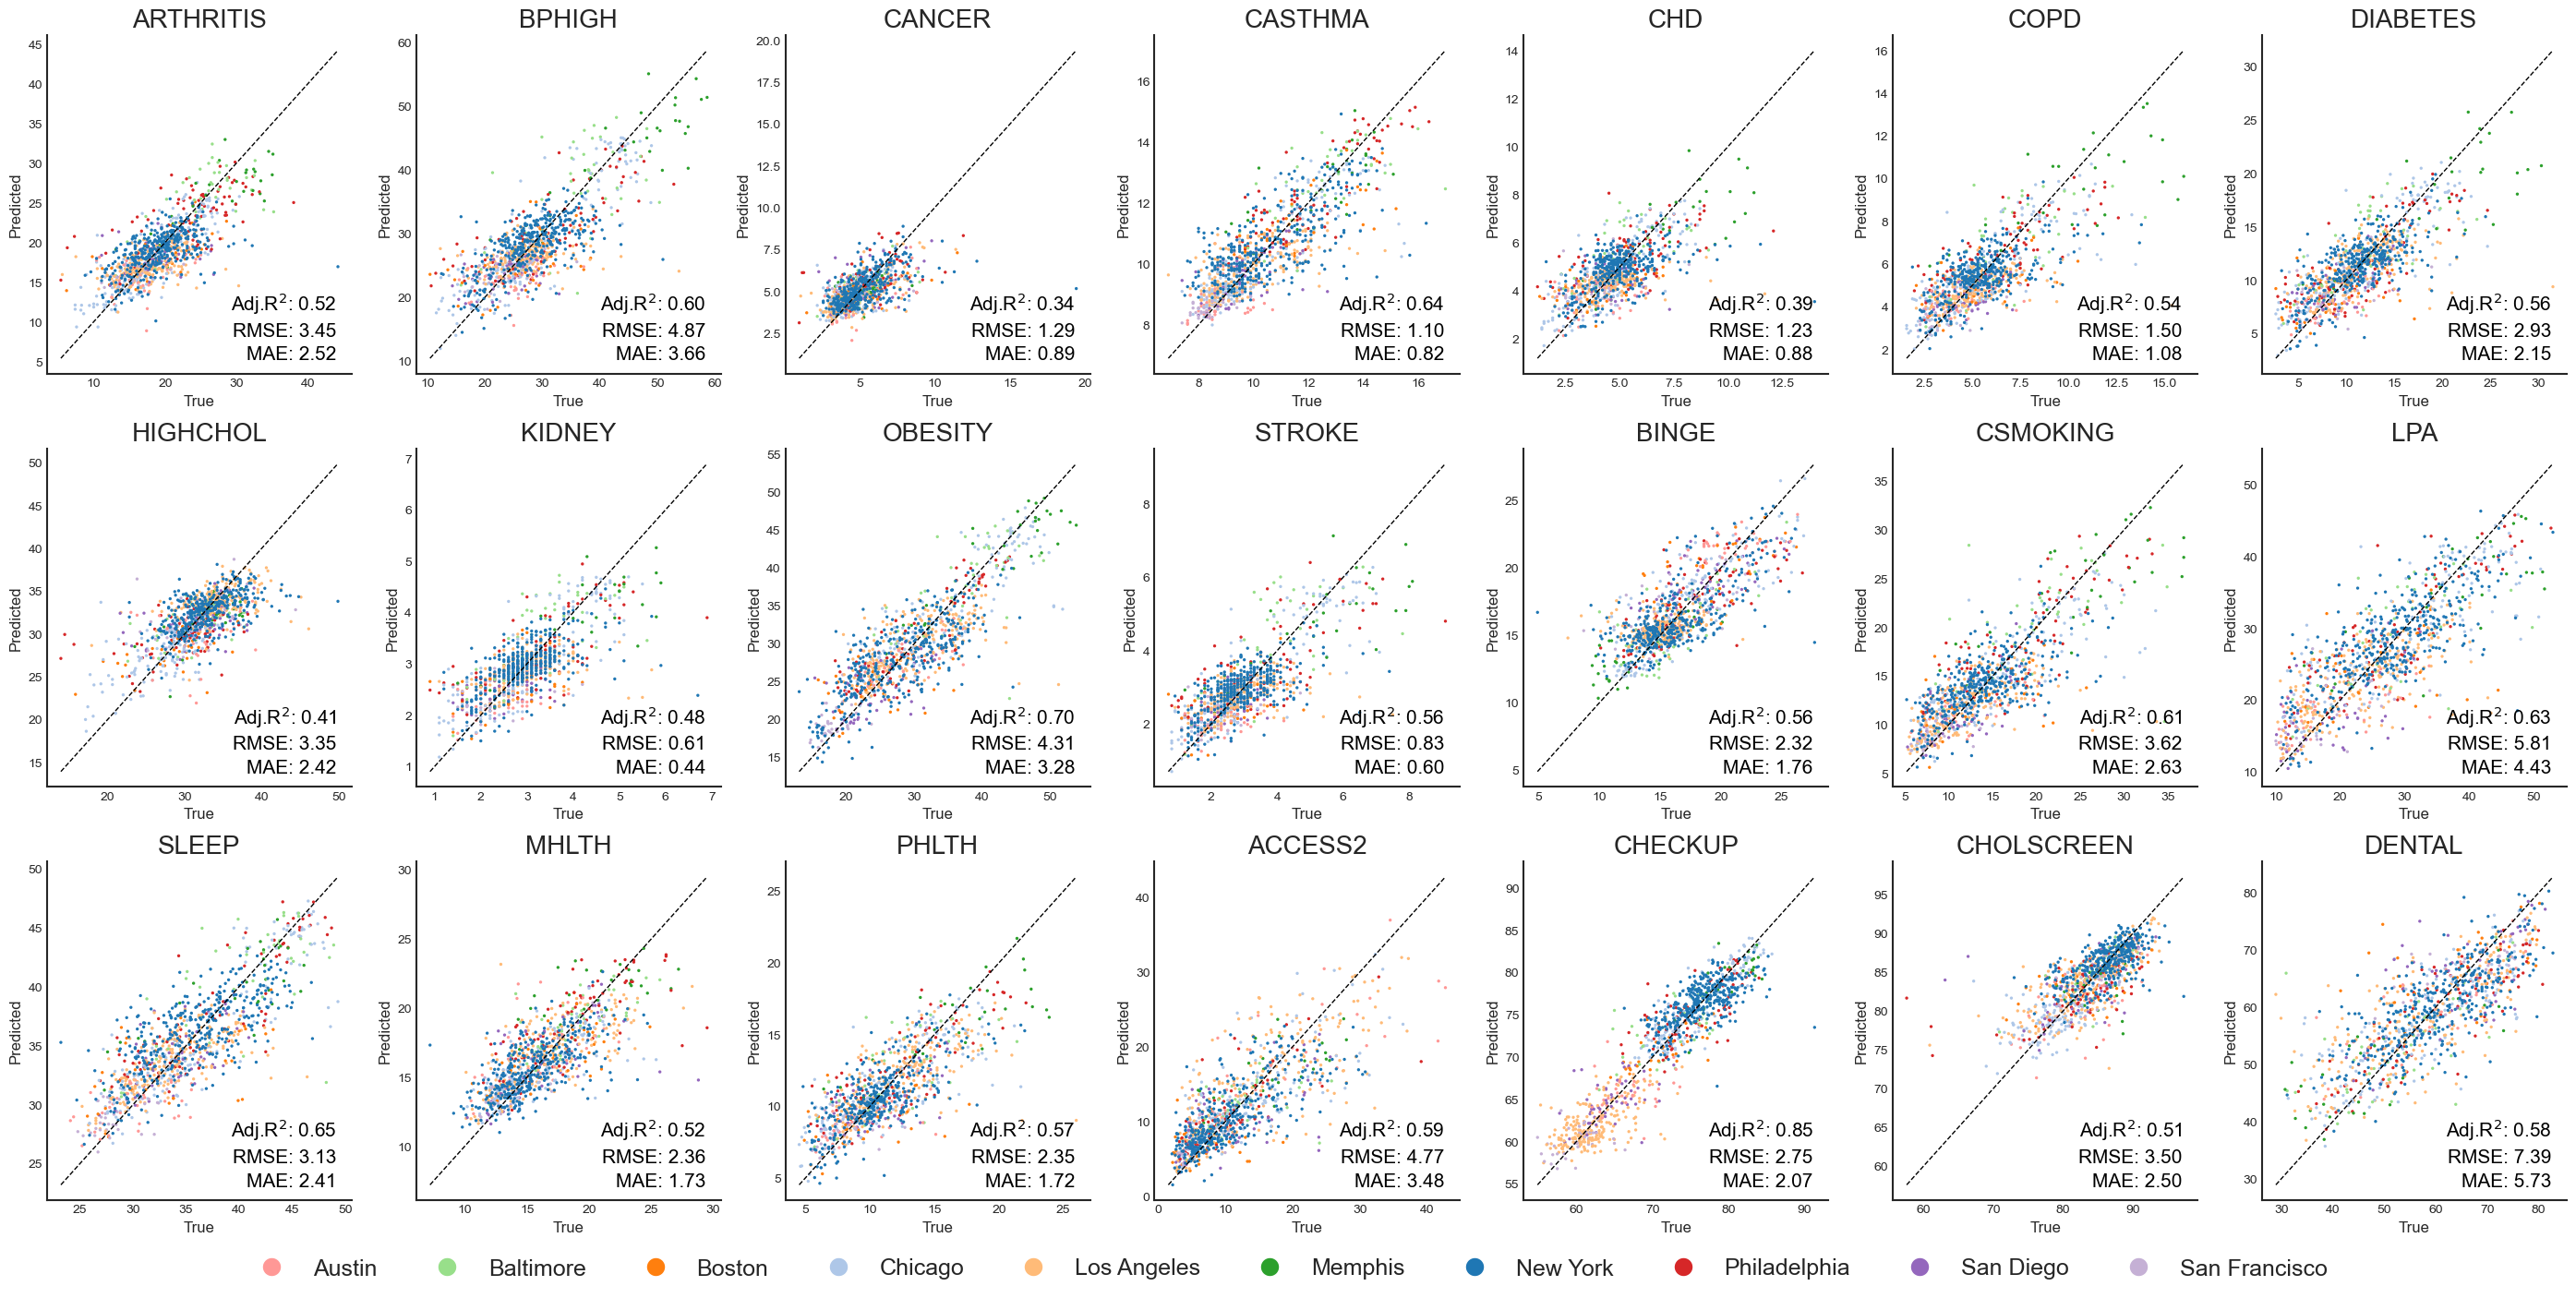

In [7]:
import importlib
import my_vis
importlib.reload(my_vis)
from my_vis import visualize_complaints_predictions

fig = visualize_complaints_predictions(
                                       df_pred=df_pred_complaint, 
                                       df_metric=df_metirc_complaint
                                       )

fig.savefig(r'YourImagePath/Figure2a.pdf', dpi=600, bbox_inches='tight')

### ***Fig.2b: model comparison***

In [8]:
df_comparison_complaint = pd.read_csv(r'ResultTables/Metrics_complaint_2022for2023.csv')
df_comparison_demographics = pd.read_csv(r'ResultTables/Metrics_demographics_2022for2023.csv')
df_comparison_hybrid = pd.read_csv(r'ResultTables/Metrics_hybrid_2022for2023.csv')

df_type = pd.read_csv(r'Dataset/Dataset_healthtype.csv', index_col=0)
df_type.columns=['y_variable', 'legends']

df_comparison = pd.merge(df_comparison_complaint, df_comparison_demographics, on='y_variable').merge(df_comparison_hybrid, on='y_variable').merge(df_type, on='y_variable')
df_comparison['r2_improvement'] = df_comparison['adjusted_r2_hybrid'] - df_comparison['adjusted_r2_demographics']

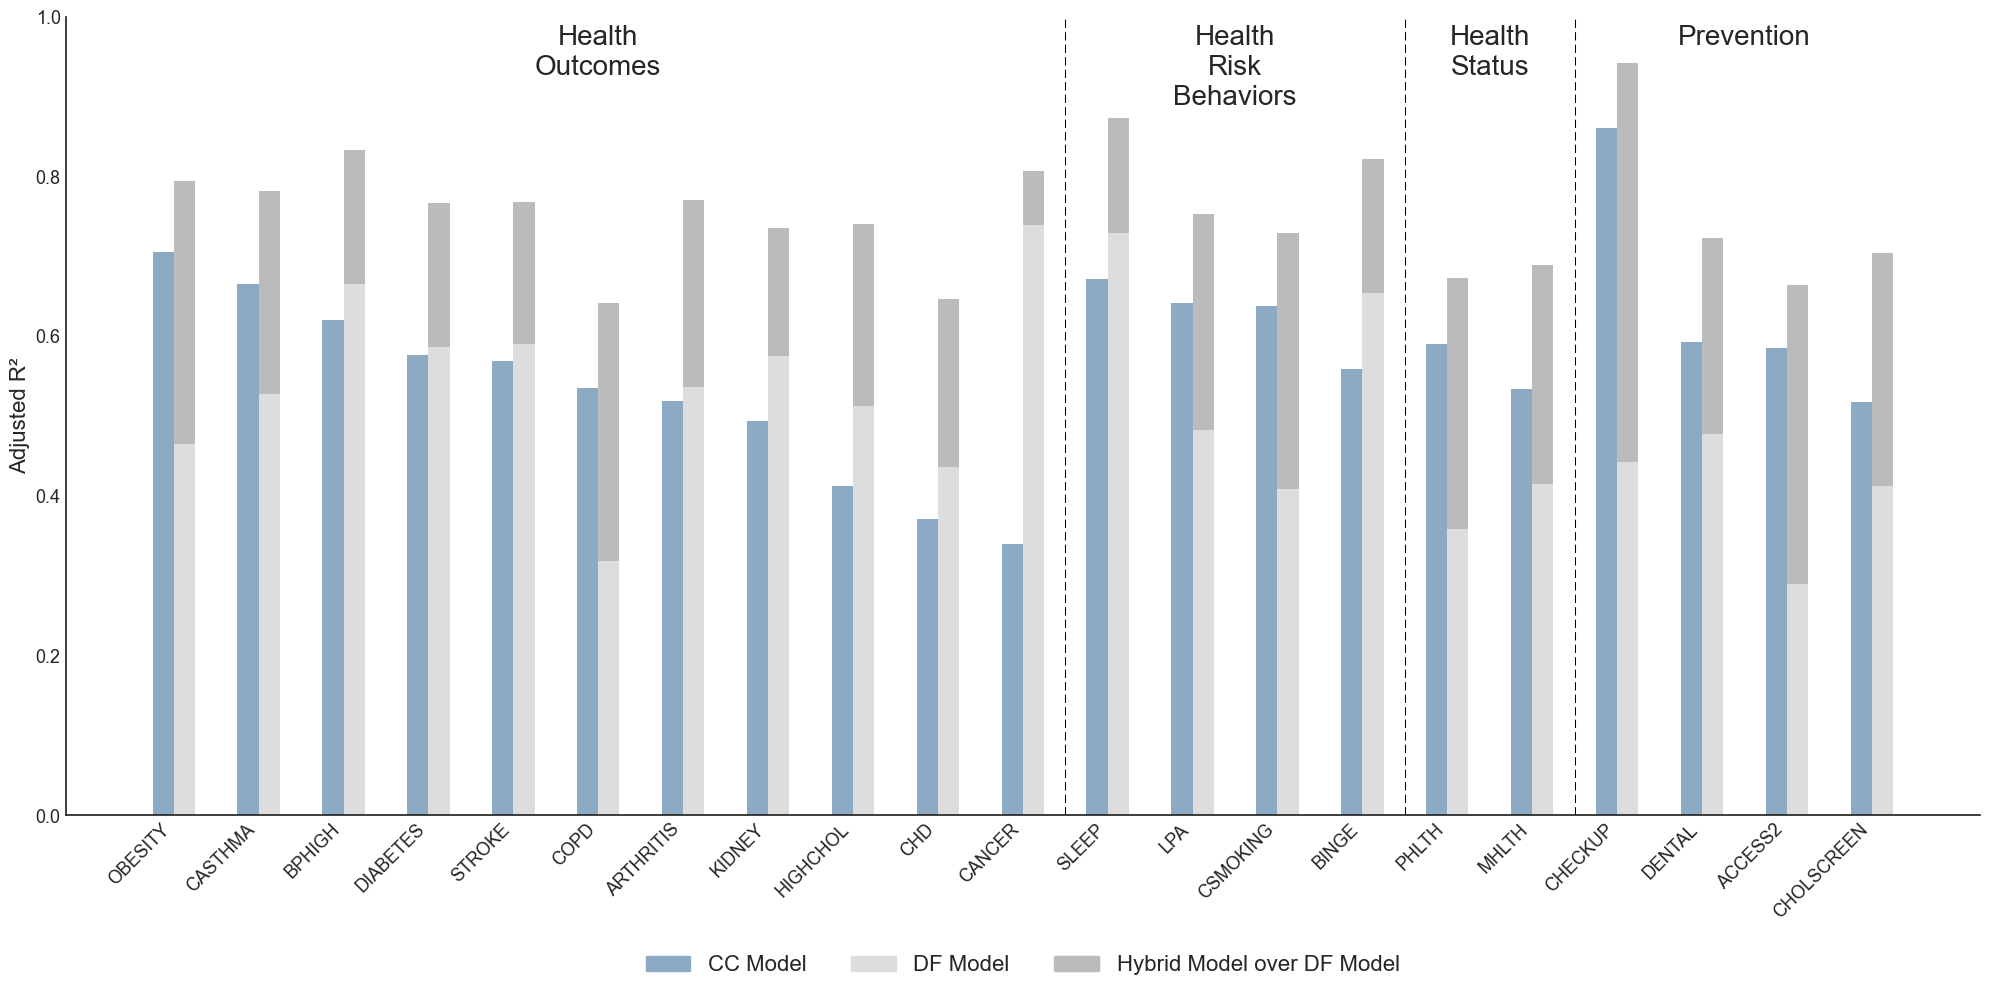

In [9]:
import importlib
import my_vis
importlib.reload(my_vis)
from my_vis import visualize_model_comparison

fig = visualize_model_comparison(
                                df_comparison=df_comparison,
                                figsize=(20, 10),
                                width=0.25,
                                color_complaint='#8CAAC4',
                                color_demographics='#DDDDDD',
                                color_improvement='#BBBBBB'
                                )

fig.savefig(r'YourImagePath/Figure2b.pdf', dpi=600, bbox_inches='tight')

### ***Fig.3: Feature contribution***

In [10]:
df_healthtype = pd.read_csv(r'Dataset/Dataset_healthtype.csv', index_col=0)
df_healthtype.columns=['y_variable','category']

measure_list = df_type['y_variable'].values.tolist()

df_shap_ = pd.read_csv(r'ResultTables/SHAP_2022for2023.csv')
df_shap_['shap_ratio'] = df_shap_.groupby('y_variable')['mean_abs_shap'].transform(lambda x: x / x.sum())

In [11]:
import importlib
import my_vis
importlib.reload(my_vis)
from my_vis import visualize_shap_ratio_lollipop

fig = visualize_shap_ratio_lollipop(
                                    df_shap_, 
                                    measure_list,
                                    figsize=(15, 6),
                                    alpha=0.9
                                    )

fig.savefig(r'YourImagePath/Fig3a.pdf', dpi=600, bbox_inches='tight')

In [12]:
import importlib
import my_vis
importlib.reload(my_vis)
from my_vis import visualize_top_feature

fig = visualize_top_feature(
                            df_shap_, df_healthtype, 
                            figsize=(15, 5), 
                            top_k=8, 
                            cmap_name='Set3', 
                            ncol=6
                            )

fig.savefig(r'YourImagePath/Fig3b.pdf', dpi=600, bbox_inches='tight')

# Part 3: Model robustness

### ***Fig.4a: across time***

In [13]:
year_pairs = [(2019, 2020), (2020, 2021), (2021, 2022), (2022, 2023)]

df_metric_all = pd.DataFrame()

for x_year, y_year in year_pairs:

    path_complaint = rf'ResultTables/Metrics_complaint_{x_year}for{y_year}.csv'
    path_demographics = rf'ResultTables/Metrics_demographics_{x_year}for{y_year}.csv'
    path_hybrid = rf'ResultTables/Metrics_hybrid_{x_year}for{y_year}.csv'

    df_complaint = pd.read_csv(path_complaint)
    df_demographics = pd.read_csv(path_demographics)
    df_hybrid = pd.read_csv(path_hybrid)

    df_metric_year = pd.merge(df_complaint, df_demographics, on='y_variable')
    df_metric_year = pd.merge(df_metric_year, df_hybrid, on='y_variable')

    df_metric_year=df_metric_year.sort_values(by='y_variable', ascending=True)

    df_metric_year['Year'] = f'{x_year} for {y_year}'

    df_metric_all = pd.concat([df_metric_all, df_metric_year], ignore_index=True)

df_metric_all = df_metric_all.rename(columns={'y_variable': 'Health Measure'})
df_metric_all

,Health Measure,adjusted_r2_complaint,rmse_complaint,mae_complaint,adjusted_r2_demographics,rmse_demographics,mae_demographics,adjusted_r2_hybrid,rmse_hybrid,mae_hybrid,Year
0,ACCESS2,0.602063,5.204807,3.931622,0.288809,7.034934,5.342237,0.699437,4.512013,3.321174,2019 for 2020
...,...,...,...,...,...,...,...,...,...,...,...
83,STROKE,0.568680,0.808611,0.580684,0.590468,0.797185,0.593957,0.768015,0.592030,0.427389,2022 for 2023


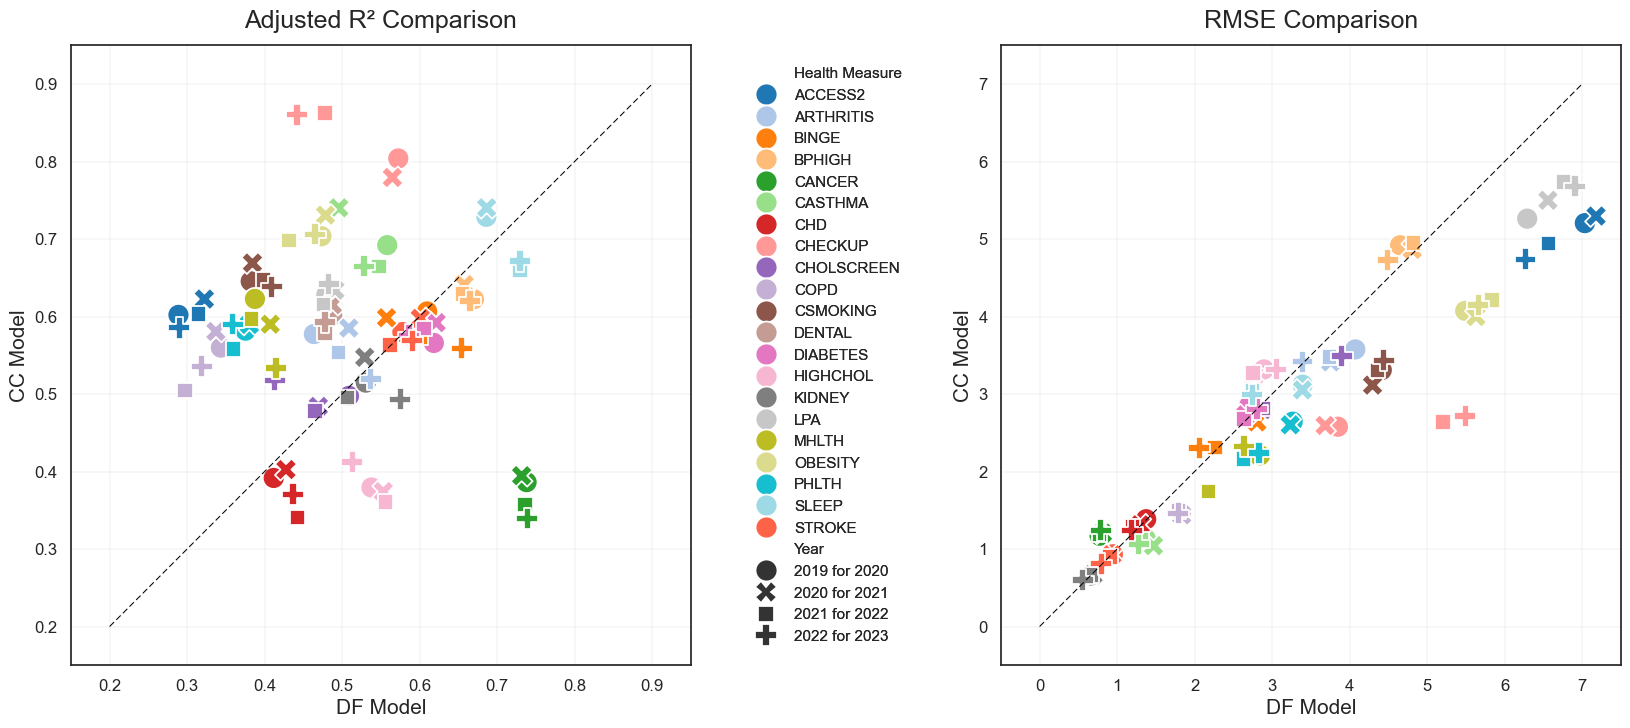

In [14]:
import importlib
import my_vis
importlib.reload(my_vis)
from my_vis import visualize_year_robustness

fig = visualize_year_robustness(
                                df_metric_all=df_metric_all,
                                xy_left=('adjusted_r2_demographics', 'adjusted_r2_complaint'),
                                xy_right=('rmse_demographics', 'rmse_complaint'),
                                s=250
                                )

fig.savefig(r'YourImagePath/Figure4a.pdf', dpi=600, bbox_inches='tight')

### ***Fig.4b: across geography***

In [15]:
r2_by_city = pd.read_csv(r'ResultTables/Metrics_bycity_R2.csv', index_col=0)
rmse_by_city = pd.read_csv(r'ResultTables/Metrics_bycity_RMSE.csv', index_col=0)

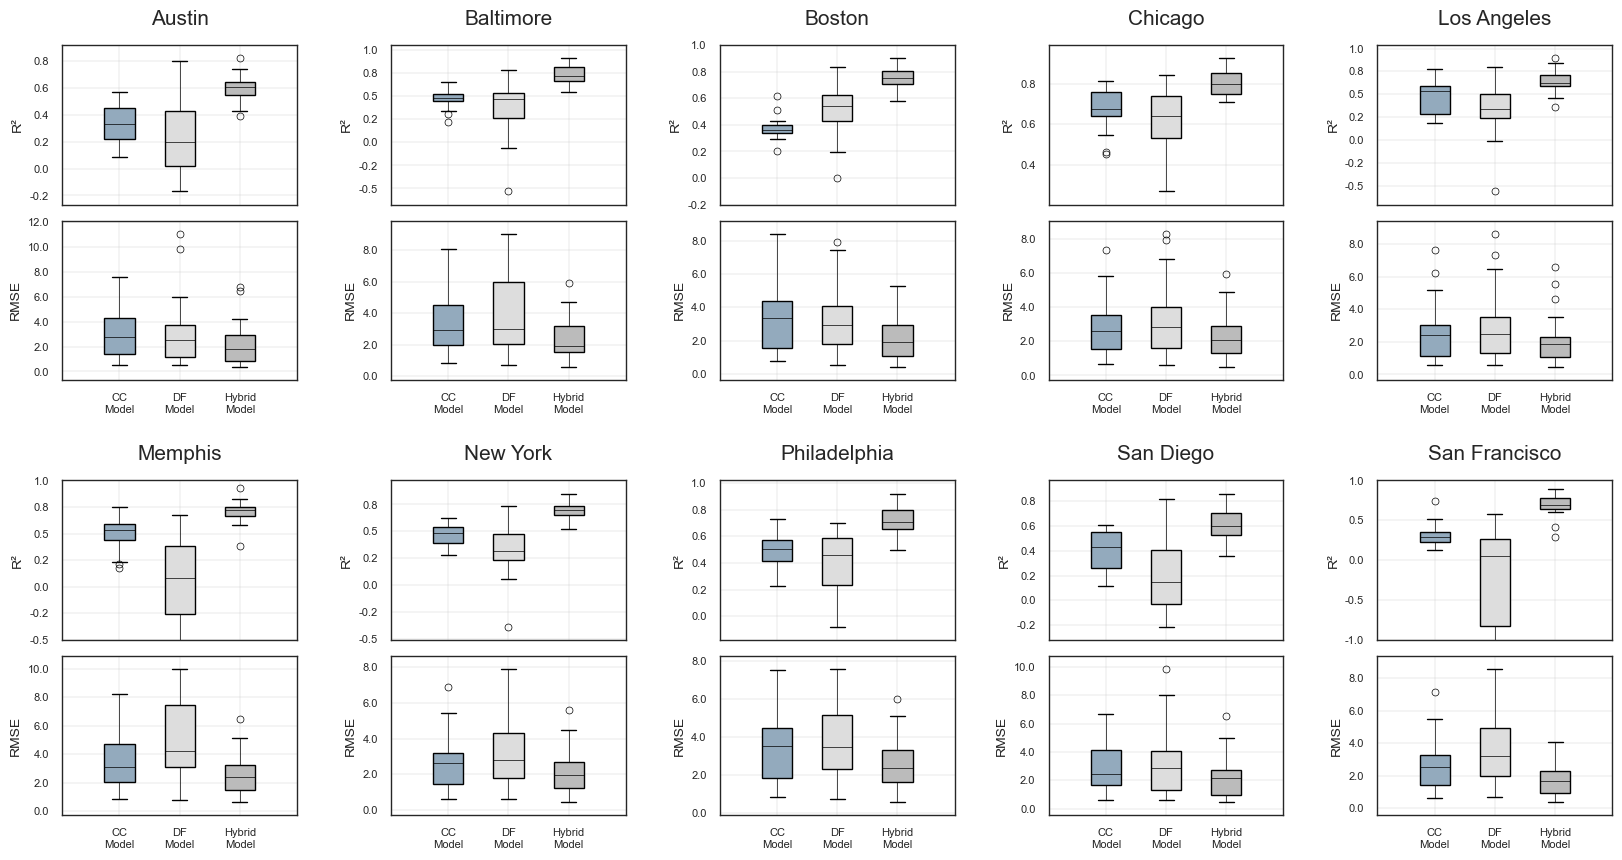

In [16]:
import importlib
import my_vis
importlib.reload(my_vis)
from my_vis import plot_metric_by_city

fig = plot_metric_by_city(
                          r2_by_city, 
                          rmse_by_city
                          )

fig.savefig(r'YourImagePath/Figure4b.pdf', dpi=600, bbox_inches='tight')

### ***Fig.5: across algorithms***

In [17]:
model_types = ['complaint', 'demographics', 'hybrid']


df_list = []
for model in model_types:
    file_path = fr'ResultTables/Metrics_{model}_2022for2023.csv'
    df = pd.read_csv(file_path)
    df.columns = ['y_variable'] + [f'{col}_LGB' for col in df.columns[1:]]
    df_list.append(df)

df_lgb= reduce(lambda left, right: pd.merge(left, right, on='y_variable'), df_list)


df_list = []
for model in model_types:
    file_path = fr'ResultTables/XGBMetrics_{model}_2022for2023.csv'
    df = pd.read_csv(file_path)
    df.columns = ['y_variable'] + [f'{col}_XGB' for col in df.columns[1:]]
    df_list.append(df)

df_xgb= reduce(lambda left, right: pd.merge(left, right, on='y_variable'), df_list)


df_list = []
for model in model_types:
    file_path = fr'ResultTables/RFMetrics_{model}_2022for2023.csv'
    df = pd.read_csv(file_path)
    df.columns = ['y_variable'] + [f'{col}_RF' for col in df.columns[1:]]
    df_list.append(df)

df_rf= reduce(lambda left, right: pd.merge(left, right, on='y_variable'), df_list)


df_list = []
for model in model_types:
    file_path = fr'ResultTables/LRMetrics_{model}_2022for2023.csv'
    df = pd.read_csv(file_path)
    df.columns = ['y_variable'] + [f'{col}_LR' for col in df.columns[1:]]
    df_list.append(df)

df_lr= reduce(lambda left, right: pd.merge(left, right, on='y_variable'), df_list)

In [18]:
df_fusion = pd.merge(df_lgb, df_xgb, on='y_variable').merge(df_rf, on='y_variable').merge(df_lr, on='y_variable')
df_fusion = df_fusion.sort_values(by='y_variable', ascending=True)
df_fusion = df_fusion.reset_index(drop=True)

df_fusion['abs_diff_XGB_LGB'] = (df_fusion['adjusted_r2_complaint_XGB'] - df_fusion['adjusted_r2_complaint_LGB']).abs()
df_fusion['abs_diff_RF_LGB'] = (df_fusion['adjusted_r2_complaint_RF'] - df_fusion['adjusted_r2_complaint_LGB']).abs()

df_fusion['rel_diff_XGB_LGB'] = df_fusion['abs_diff_XGB_LGB'] / df_fusion['adjusted_r2_complaint_LGB']
df_fusion['rel_diff_RF_LGB'] = df_fusion['abs_diff_RF_LGB'] / df_fusion['adjusted_r2_complaint_LGB']

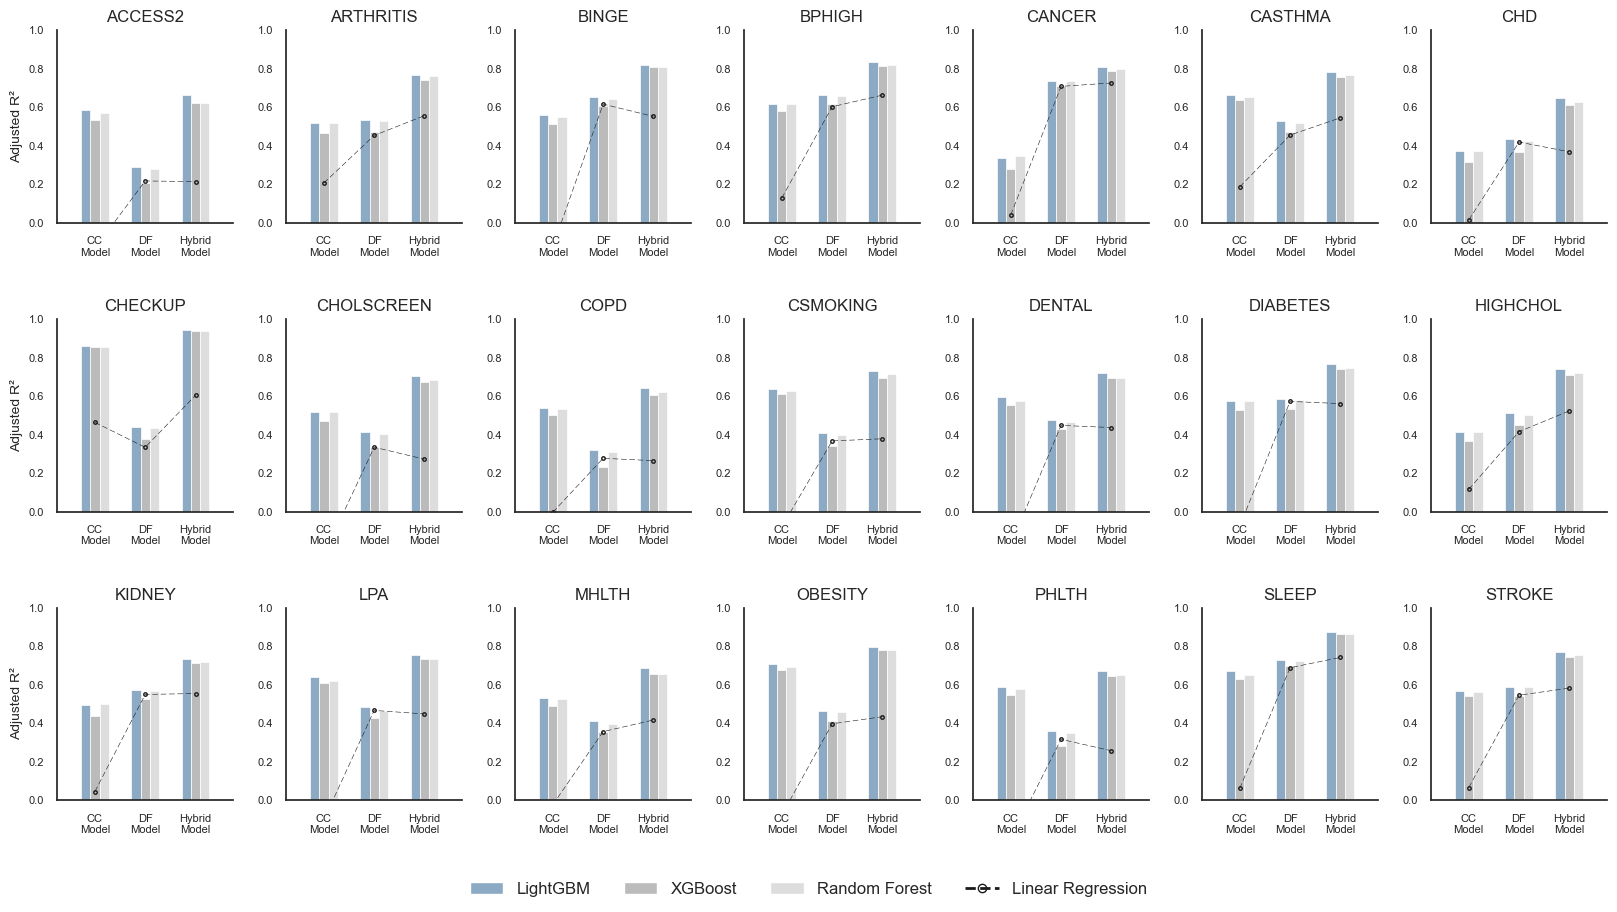

In [19]:
import importlib
import my_vis
importlib.reload(my_vis)
from my_vis import visualize_architecture_robustness

fig = visualize_architecture_robustness(
                                        df_fusion, 
                                        models_to_show=['LGB', 'XGB', 'RF', 'LR'],
                                        linewidth=0.4, markersize=2.5, 
                                        hspace=0.5, wspace=0.3
                                       )

fig.savefig(r'YourImagePath/Figure5.pdf', dpi=600, bbox_inches='tight')